In [1]:
import numpy as np
import random
import os 

from PIL import Image
from skimage import io

import torch 
from torch import  optim
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms.functional import normalize as F_normalize

!pip install tb-nightly
!pip install future



import matplotlib.pyplot as plt
%matplotlib inline

#### Download Data

In [2]:
!wget --directory-prefix=data/  http://www.mimuw.edu.pl/~ciebie/cityscapes.tgz 
!tar -xzf data/cityscapes.tgz -C data/
!python data/cityscapes/check_close.py # Check files
!rm data/cityscapes.tgz
!rm data/cityscapes/README.md
!rm data/cityscapes/check_close.py
!rm -r  data/cityscapes/.ipynb_checkpoints

DATASET_FOLDER = "data/cityscapes"
PIXELS_IN_PIC = 256 *256

--2019-05-08 16:48:40--  http://www.mimuw.edu.pl/~ciebie/cityscapes.tgz
Resolving www.mimuw.edu.pl (www.mimuw.edu.pl)... 193.0.96.14
Connecting to www.mimuw.edu.pl (www.mimuw.edu.pl)|193.0.96.14|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.mimuw.edu.pl/~ciebie/cityscapes.tgz [following]
--2019-05-08 16:48:40--  https://www.mimuw.edu.pl/~ciebie/cityscapes.tgz
Connecting to www.mimuw.edu.pl (www.mimuw.edu.pl)|193.0.96.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 310275605 (296M) [application/x-gzip]
Saving to: ‘data/cityscapes.tgz’

cityscapes.tgz      100%[===================>] 295.90M  35.5MB/s    in 9.8s    

2019-05-08 16:48:50 (30.2 MB/s) - ‘data/cityscapes.tgz’ saved [310275605/310275605]

rm: cannot remove 'data/cityscapes/.ipynb_checkpoints': No such file or directory


#### Define device to train on

In [0]:
global device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Data preprocessing

#### Dataset class

In [0]:
class CityScapes(torch.utils.data.Dataset):
    def __init__(self, path, transform = None):
        self.data_folder = path
        self.len = len(os.listdir(path))
        self.transform = transform
        
    def __getitem__(self, idx):
        path_to_file = os.path.join(self.data_folder,os.listdir(self.data_folder)[idx-1])
        image = io.imread(path_to_file)
        
        if self.transform:
            image = self.transform(image)
        return image
    
    def __len__(self):
        return self.len

#### Array with classes for segmentation

##### Function to convert RGB picture to feature map
##### source: https://stackoverflow.com/questions/33196130/replacing-rgb-values-in-numpy-array-by-integer-is-extremely-slow

In [0]:
def RGB_to_idx(image, arr_to_idx):
    image = image.dot(np.array([65536, 256, 1], dtype='int32'))
    result = np.ndarray(shape=image.shape, dtype=int)
    result[:,:] = -1
    for rgb, idx in arr_to_idx.items():
        rgb = rgb[0] * 65536 + rgb[1] * 256 + rgb[2]
        result[image==rgb] = idx
    return result

def idx_to_RGB(image, idx_to_rgb):
    result = np.ndarray(shape=(256,256,3), dtype=int)
    result[:,:,:] = -1
    for x in range(256):
      for y in range(256):
        result[x][y] = idx_to_arr[int(image[x][y])]
    return result
  
  
  
check_array = np.array(
    [[116, 17, 36],[152, 43,150],
     [106,141, 34],[ 69, 69, 69],
     [  2,  1,  3],[127, 63,126],
     [222, 52,211],[  2,  1,140],
     [ 93,117,119],
     [180,228,182],[213,202, 43],
     [ 79,  2, 80],[188,151,155],
     [  9,  5, 91],[106, 75, 13],
     [215, 20, 53],[110,134, 62],
     [  8, 68, 98],[244,171,170],
     [171, 43, 74],[104, 96,155],
     [ 72,130,177],[242, 35,231],
     [147,149,149],[ 35, 25, 34],
     [155,247,151],[ 85, 68, 99],
     [ 71, 81, 43],[195, 64,182],
     [146,133, 92]]
)

arr_to_idx = {tuple(arr):idx for idx,arr in enumerate(check_array)}
idx_to_arr = {idx: arr for idx,arr in enumerate(check_array)}

#### Custom Transformations

In [0]:
class Split_N(object):
    def __call__(self,sample):
      return sample[:,:256,:].astype("float32"), sample[:,256:,:].astype("float32")

class Split(object):
    def __call__(self,sample):
      return sample[:,:256,:], sample[:,256:,:]

    
# trsf = transforms.Compose([Split()])
# dataset = CityScapes(DATASET_FOLDER, transform=trsf)

#### Create DataLoader for training and validation

In [0]:
# indices = np.arange(dataset.__len__())
# np.random.shuffle(indices)

# # Random indices for training and validation Ratio 2975 / 500 
# val_indices, train_indices =  indices[:500], indices[500:]

# train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
# val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# # train_loader = DataLoader(dataset, batch_size = 8, sampler = train_sampler) 
# # val_loader = DataLoader(dataset, batch_size = 8, sampler = val_sampler)


#### Calculate *mean* and *std*

In [0]:
#train_loader = DataLoader(dataset, batch_size = len(train_sampler.indices), sampler = train_sampler) 
#for data,_ in train_loader:
#     std = [data[:,:,:,0].std(),data[:,:,:,1].std(),data[:,:,:,2].std()]
#     mean = [data[:,:,:,0].mean(),data[:,:,:,1].mean(),data[:,:,:,2].mean()]    

In [0]:
class HorizontalFlip_Normalize(object):
    
    def __init__(self,mean,std):
      self.mean = mean
      self.std = std
      
    def __call__(self,sample):
        X,y = sample
        
        y = RGB_to_idx(y,arr_to_idx)
        if np.random.random() > 0.5:
            X[:], y[:] = X[:,::-1,:],y[:,::-1]
            
        X = transforms.functional.to_tensor(X)
        return (F_normalize(X, self.mean, self.std), torch.from_numpy(y))
      
class HorizontalFlip(object):
   
    def __call__(self,sample):
        X,y = sample
        
        y = RGB_to_idx(y,arr_to_idx)
        if np.random.random() > 0.5:
            X[:], y[:] = X[:,::-1,:],y[:,::-1]
            
        X = transforms.functional.to_tensor(X)
        return (X, torch.from_numpy(y))
      
            

#### Data Loader with normalization

In [0]:
mean_calc = [22.0289,22.0289,22.0289]
std_calc = [47.1833,47.7054,47.2338]

trsf = transforms.Compose([Split(),HorizontalFlip()])
dataset = CityScapes(DATASET_FOLDER, transform=trsf)



indices = np.arange(dataset.__len__())
np.random.shuffle(indices)

# Random indices for training and validation Ratio 2975 / 500 
val_indices, train_indices =  indices[:500], indices[500:]

train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)


train_loader = DataLoader(dataset, batch_size = 8, sampler = train_sampler) 
val_loader = DataLoader(dataset, batch_size = 8, sampler = val_sampler)

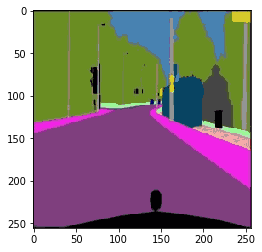

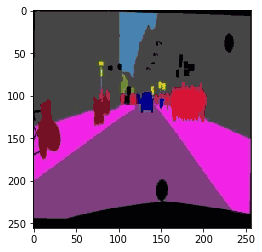

In [10]:
for i in range(2):
  plt.imshow(idx_to_RGB(dataset[1024+i][1],idx_to_arr))
  plt.pause(1)

#### Class balance

In [0]:
def make_histogram(dataset):
  dict_classes  = { idx:0 for idx in range(30)}
  
  for i in range(dataset.len):
      _, y = dataset[i]
      for class_idx in dict_classes.keys():
        dict_classes[class_idx] += np.sum(np.where(y == class_idx, 1, 0))
  return dict_classes 
classes_freq_dictionary = make_histogram(dataset)

In [0]:
def make_weight(dict_hist):
    num_class = len(dict_hist.keys())
    weight = np.empty(num_class)
    
    total_pixels = np.sum( list(dict_hist.values()) )
    
    for i in range(num_class):
      weight[i] =  dict_hist[i] /total_pixels
    return torch.Tensor(weight)
global weight  
weight = make_weight(classes_freq_dictionary)

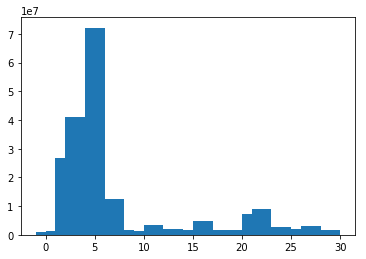

In [13]:
plt.bar(classes_freq_dictionary.keys(), classes_freq_dictionary.values(), width=2,);

### Defining U-net

In [0]:
def make_block(in_channels, out_channels):
    block = nn.Sequential(nn.ReplicationPad2d(1),
                              nn.Conv2d(in_channels, out_channels, 3,),
                              nn.ReLU(),
                              nn.BatchNorm2d(out_channels),
                              nn.ReplicationPad2d(1),
                              nn.Conv2d(out_channels, out_channels, 3),
                              nn.ReLU(),
                              nn.BatchNorm2d(out_channels)
                             )
    if (device.type == "cuda"):
        block.type(torch.cuda.FloatTensor)
    return block

In [0]:
class UNet(nn.Module):
    def __init__(self, basic_chl,num_classes = 30,image_channels = 3):
        super(UNet, self).__init__()
        
        #Calculate channels based on basic channel
        BL1_chl, BL2_chl, BL3_chl, BL4_chl, BL5_chl= [basic_chl * i for i in [1,2,4,8,16]]
        
        #Encoder blocks
        self.ENC_BL1 = make_block(image_channels,BL1_chl)
        self.ENC_BL2 = make_block(BL1_chl,BL2_chl)
        self.ENC_BL3 = make_block(BL2_chl,BL3_chl)
        self.ENC_BL4 = make_block(BL3_chl,BL4_chl)
        self.ENC_BL5 = make_block(BL4_chl,BL5_chl)
        
        #MaxPool for downsampling
        self.MaxPool = nn.MaxPool2d(2,2)
        
        #UpConv for upsampling
        self.UpConv1 = nn.ConvTranspose2d(BL5_chl, BL4_chl, 2, stride = 2)
        self.UpConv2 = nn.ConvTranspose2d(BL4_chl, BL3_chl, 2, stride = 2)
        self.UpConv3 = nn.ConvTranspose2d(BL3_chl, BL2_chl, 2, stride = 2)
        self.UpConv4 = nn.ConvTranspose2d(BL2_chl, BL1_chl, 2, stride = 2)
        
        #Decoder blocks
        self.DEC_BL1 = make_block(BL5_chl,BL4_chl)
        self.DEC_BL2 = make_block(BL4_chl,BL3_chl)
        self.DEC_BL3 = make_block(BL3_chl,BL2_chl)
        self.DEC_BL4 = make_block(BL2_chl,BL1_chl)
        
        # Last convolution
        self.Final_CONV = nn.Conv2d(basic_chl, num_classes, 1)
        
    
    def forward(self,X):
        # Encoder
        ENC_1_out = self.ENC_BL1.forward(X)
        MaxENC_1_out = self.MaxPool.forward(ENC_1_out)
        
        ENC_2_out = self.ENC_BL2.forward(MaxENC_1_out)
        MaxENC_2_out = self.MaxPool.forward(ENC_2_out)
        
        ENC_3_out = self.ENC_BL3.forward(MaxENC_2_out)
        MaxENC_3_out = self.MaxPool.forward(ENC_3_out)
        
        ENC_4_out = self.ENC_BL4.forward(MaxENC_3_out)
        MaxENC_4_out = self.MaxPool.forward(ENC_4_out)
                
        # Bridge to Decoder
        ENC_5_out = self.ENC_BL5.forward(MaxENC_4_out)
        UpENC_5_out = self.UpConv1.forward(ENC_5_out)  
        
        #Decoder
        DEC_1_in = torch.cat((UpENC_5_out,ENC_4_out), dim = 1)
        DEC_1_out = self.DEC_BL1.forward( DEC_1_in)
        UpDEC_1_out = self.UpConv2.forward(DEC_1_out)
        
        
        DEC_2_in = torch.cat((UpDEC_1_out,ENC_3_out), dim = 1)
        DEC_2_out = self.DEC_BL2.forward(DEC_2_in)
        UpDEC_2_out = self.UpConv3.forward(DEC_2_out)
        
        DEC_3_in = torch.cat((UpDEC_2_out,ENC_2_out), dim = 1)
        DEC_3_out = self.DEC_BL3.forward(DEC_3_in)
        UpDEC_3_out = self.UpConv4.forward(DEC_3_out)
        
        DEC_4_in = torch.cat((UpDEC_3_out,ENC_1_out), dim = 1)
        DEC_4_out = self.DEC_BL4.forward(DEC_4_in)
          
        #Final Convolution    
        segmenatation_map = self.Final_CONV.forward(DEC_4_out)
    
        return segmenatation_map

### Compute Validation

In [0]:
def compute_validation_accuracy(model, val_loader):
    model.eval()
    
    acc_accum = 0.0
    PIXELS_IN_BATCH = PIXELS_IN_PIC * val_loader.batch_size
    for idx,(X,y) in enumerate(val_loader):
            
        x = X.to(device)
        y = y.to(device)
                
        prediction = torch.argmax( model(x), dim = 1)   
        acc_accum += float(torch.sum(prediction == y))/PIXELS_IN_BATCH
        
    accuracy = acc_accum / val_loader.__len__()    
    return accuracy
  

def visualize_random_sample(model, loader = val_loader,num_samples = 3):
    model.eval()
    random_idx = np.random.choice(loader.sampler.indices, size = num_samples)
    fig, axs = plt.subplots(num_samples,3, figsize=(10,10))
    
    for ax in axs:
      for obj in ax:
          obj.axis("off")
    
    for i,idx in enumerate(random_idx):
        X,y = dataset[idx]
        
        
        axs[i,0].imshow(X.permute(1,2,0))
        axs[i,1].imshow(idx_to_RGB(y, idx_to_arr))
                
        X = X.to(device)
        y = y.to(device)
        
        pred = torch.argmax( model(X.unsqueeze(0)) ,dim=1) 
        axs[i,2].imshow(idx_to_RGB(pred[0].cpu(), idx_to_arr))
        
        
        idx_acc = float(torch.sum(pred == y))/PIXELS_IN_PIC
        print("accuracy on {0} validation example : {1:.2f} ".format(i,idx_acc)) 

### Training function

In [0]:
def train_model(model, optimizer, loss_function, num_epochs, scheduler_obj ,train_loader, val_loader = None, verbose = False):         
    train_loss_history, train_acc_history, val_acc_history = [], [], []
    
    scheduler = scheduler_obj
    
    for epoch in range(num_epochs):
        model.train()
    
        train_acc_accum = 0.0
        running_loss = 0
        scheduler.step()
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            
            output = model(x) # batch_size x num_classes x height x width
            pred = torch.argmax(output, dim=1)
            
            optimizer.zero_grad()
            
            loss = loss_function(output,y)
            train_acc_accum += float(torch.sum(pred == y))/ (x.shape[0] * PIXELS_IN_PIC) ##ACC_METRIC
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        train_acc = train_acc_accum / train_loader.__len__()
        val_acc = "-" if (val_loader == None) else compute_validation_accuracy(model, val_loader)
        loss_norm = running_loss / train_loader.__len__()
        
        if (verbose):
          print("Epoch: {0}, tr_loss = {1:.4f} , tr_acc = {2:.3f}, val_acc = {3}".format(epoch+1, loss_norm, train_acc, val_acc) )
        
        train_loss_history.append(loss_norm)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        
    return train_loss_history, train_acc_history, val_acc_history

In [0]:
sched = torch.optim.lr_scheduler.StepLR

a,b, c = train_model(model,train_toy_loader, optim, loss, 4, sched, [5,0.1], val_loader=val_toy_loader, verbose = True)

### Toy Dataset for sanity check

In [0]:
### Create toy dataset to check  implementation
np.random.seed(42)

tr_toy_size = 1
val_toy_size = 1 
toy_batch = 1

tr_toy_ind = [1027]#np.random.choice(train_indices, size = tr_toy_size) 
val_toy_ind =[1024] #np.random.choice(val_indices, size = val_toy_size) 


train_toy_sampler = torch.utils.data.SubsetRandomSampler(tr_toy_ind)
val_toy_sampler = torch.utils.data.SubsetRandomSampler(val_toy_ind) 

train_toy_loader = DataLoader(dataset=dataset, batch_size=toy_batch, sampler= train_toy_sampler)
val_toy_loader = DataLoader(dataset=dataset, batch_size= toy_batch, sampler = val_toy_sampler)

### Model Initialization

In [0]:
model = UNet(128)
model.to(device)
loss = torch.nn.CrossEntropyLoss(weight=weight)

if (device.type == "cuda"):
    model.type(torch.cuda.FloatTensor)
    loss.type(torch.cuda.FloatTensor)

optim = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-5)

Epoch: 1, tr_loss = 1.6119 , tr_acc = 0.584 
Epoch: 2, tr_loss = 0.7610 , tr_acc = 0.694 
Epoch: 3, tr_loss = 0.4474 , tr_acc = 0.723 


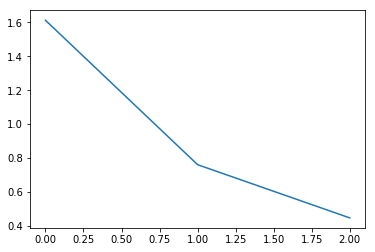

In [30]:
train_loss_history, train_acc_history = train_model(model,train_loader, optim, loss ,3)
plt.plot(train_loss_history)

### Training process

Epoch: 1, tr_loss = 1.5756 , tr_acc = 0.673 
Epoch: 2, tr_loss = 1.0594 , tr_acc = 0.745 
Epoch: 3, tr_loss = 0.9088 , tr_acc = 0.769 


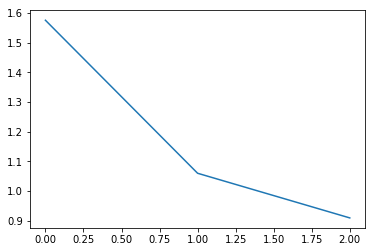

In [20]:
train_loss_history, train_acc_history = train_model(model,train_loader, optim, loss, 3, 10, 1)
plt.plot(train_loss_history)

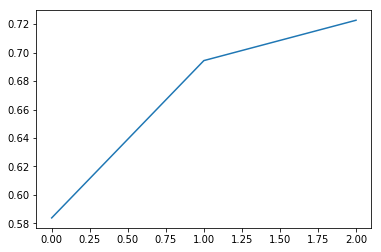

In [33]:
plt.plot(train_acc_history)

0.7212058476039341
accuracy on 0 validation example : 0.75 
accuracy on 1 validation example : 0.75 


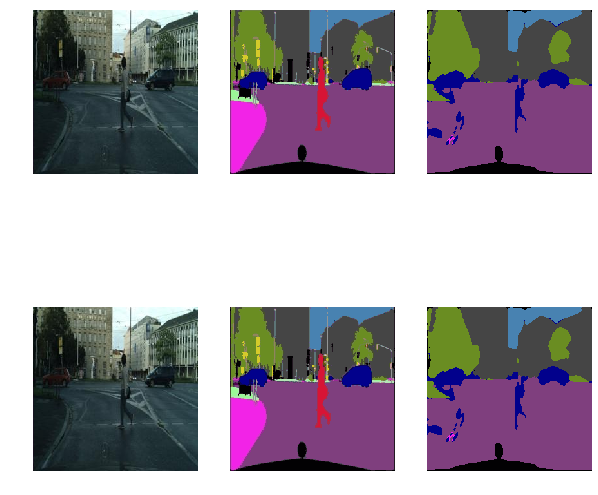

In [32]:
print(compute_validation_accuracy(model, val_loader))

visualize_random_sample(model,loader=val_loader, num_samples=2)

In [0]:
print(compute_validation_accuracy(model, val_toy_loader))

visualize_random_sample(model,loader=val_toy_loader, num_samples=2)

In [0]:
from torch.utils.tensorboard import SummaryWriter
 

writer = SummaryWriter("runs/exp1",)


# grid = torchvision.utils.make_grid(images)
# writer.add_image('images', grid, 0)
writer.add_graph(model, next(iter(train_loader))[0].to(device) )
writer.add_text("params", "lr=10")
writer.add_scalar("lr",optim.param_groups[0]["lr"])
writer.close()


In [0]:
from tensorflow import summary
%load_ext tensorboard

In [0]:
torch.tf


writer.add_graph(model, next(iter(train_loader))[0].to(device) )
writer. add_text("params", "lr=10")
writer.file_writer.add_scalar("lr",optim.param_groups[0]["lr"])

%tensorboard --logdir=content/runs/exp1/

### Random Hyper-parameter search
    Parameters:
    - learning rate
    - weight decay
    
    
    Algorithm:
    1) Get random sample from search space
    2) Define model with given parameters and train 1 epoch. Check whether training starts well
    3) 
    5) Final search performs N times and return best parameters

In [0]:
dict_params = {
    "lr" : [-10,-3],
    "L2" : [-6,-1],
    "scheduler" : [ ["StepLR", [3,4,5,10], [0.1,0.5,0.9]], [ ["CosineLR",[1],[2]]] ],
    "loss" : ["CCE"],
    "optimizer": ["Adam", "SGD"]
}

def make_sample(params):
  sample_dict={}
  
  for key,value in params.items():
    
    if  (key == "optimizer"):
      sampled_param = np.random.choice(value)  
    elif (key == "loss"):
      sampled_param = torch.nn.CrossEntropyLoss(weight = weight)
    elif (key == "scheduler"):
      sch  = sampled_param = np.random.choice(value)
      sampl_param = 
      sampled_param = sch[0](*sch[1:])
    else:
      sampled_param = 10 ** np.random.uniform(low = value[0], high = value[1]) 
      
    sample_dict[key] = sampled_param

  return sample_dict

def Random_search(model, dict_of_params, N, train_loader, val_loader):
    dict_evaluations = [ ]
    
    for i in range(N):
        
        # Get random parameters
        sample = make_sample(dict_of_params)
    
        # Define model
        model_def = model
        if (sample["optimizer"] == "Adam"):
            optimizer = torch.optim.Adam(model_def.parameters(), lr = sample["lr"], weight_decay = sample["L2"])
        elif (sample["optimizer"] == "SGD"):
            optimizer = torch.optim.SGD(model_def.parameters(), lr = sample["lr"], momentum = 0.9 , weight_decay = sample["L2"] )         
        loss = sample["loss"](weight)
        
        #perform training
        train_loss_h, train_acc, val_acc_history = train_model(model_def, optimizer, loss, sample["scheduler"], train_loader, val_loader = val_loader, epoch = 5 ,verbose = False)
        
        dict_evaluations.append([sample, [train_loss_h, train_acc, val_acc_history]])
                  
            
        dict_evaluations[tuple([(name,val) for name,val in sample])] = val_acc_history
        
    return dict_evaluations

In [90]:
make_sample(dict_params)

TypeError: ignored

In [0]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

# Writer will output to ./runs/ directory by default
writer = SummaryWriter("runs/new2")

model = UNet(64)
model.to(device)

images = next(iter(train_toy_loader))[0].to(device)


writer.add_graph(model, images)
writer.close()


In [0]:
%tensorboard --logdir=runs/new2